# Clustering

In [584]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# KMEANS
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer 
from yellowbrick.cluster import silhouette_visualizer 

# DBSCAN
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

# HIERARCHICAL
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import AgglomerativeClustering

# EMA
from pyclustering.cluster.ema import ema, ema_visualizer
from pyclustering.cluster import cluster_visualizer_multidim

# Visualization
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"
pio.templates.default = "seaborn"
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Preparation

In [585]:
df_players = pd.read_csv("./datasets/players.csv", index_col=0)
feautures = ['max_tourney_revenue', 'mean_rank_points', 'lrpOnMxrp', 'matches_won_ratio']

In [586]:
for feature in feautures:
    df_players[feature].hist().show()

## K-means

### Normalization

In this particular case, it is applied a logarithmic transformation over `mean_rank_points` and `variance_rank_points` to make them more gaussian-like.

In [587]:
df_data = df_players[feautures].reset_index(drop=True)
df_data = df_data.round(3)

# Transformations
df_data['mean_rank_points'] = np.log(df_data['mean_rank_points'])

# Plot
df_data['mean_rank_points'].hist().show()
df_data = pd.DataFrame(MinMaxScaler().fit_transform(df_data), columns=df_data.columns)
df_data.boxplot(column=feautures).show()

### Find Optimal K

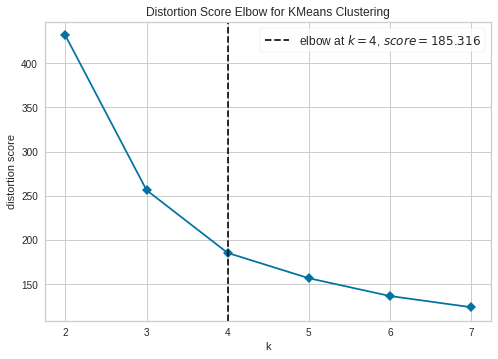

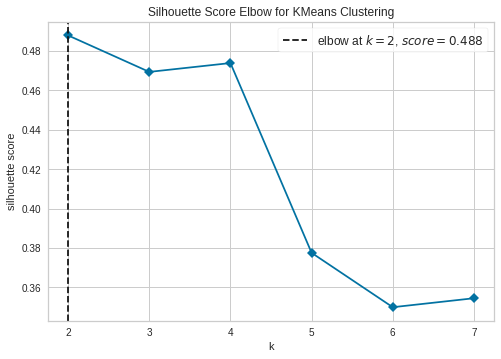

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [588]:
model = KMeans(n_init=10, max_iter=100, init="k-means++")
sse_visualizer = KElbowVisualizer(model, k=(2,8), timings=False)
sse_visualizer.fit(df_data)
sse_visualizer.show()

sil_visualizer = KElbowVisualizer(model, k=(2,8), timings=False, metric="silhouette")
sil_visualizer.fit(df_data)
sil_visualizer.show()

Picking optimal K

The optimal `k` is 4

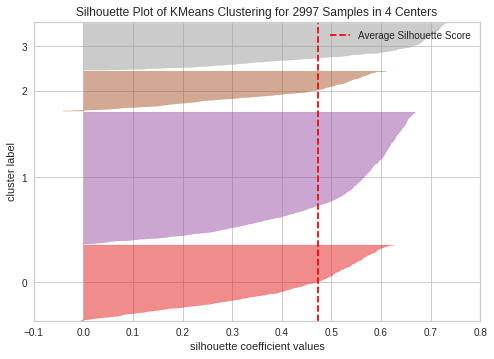

The silhoutte score is: 0.47386470306349926


In [589]:
optimal_k = sse_visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_k, n_init=10, max_iter=100, init="k-means++")
kmeans.fit(df_data)

df_players["cluster_kmeans"] = kmeans.labels_.astype(str)

x = silhouette_visualizer(KMeans(optimal_k, random_state=42), df_data)
print("The silhoutte score is: " + str(x.silhouette_score_))

### Result analysis

In [590]:
interesting_features = ['mean_rank_points', 'lrpOnAvgrp', 'age', 'total_matches_played', 'performance_index_entropy']
df_players.groupby("cluster_kmeans").agg({"cluster_kmeans":"count", "mean_rank_points": "mean", "lrpOnAvgrp": "mean", "age": "mean", "matches_won_ratio": "mean", "total_matches_played": "mean", "performance_index_entropy":"mean"}).sort_values(by="mean_rank_points", ascending=False).round(2).rename(columns={"cluster_kmeans": "cluster size"})

cluster size  mean_rank_points  lrpOnAvgrp    age  \
cluster_kmeans                                                      
0                        407            631.75        0.59  25.53   
3                        477            559.28        1.86  21.25   
2                        768             54.07        0.59  22.49   
1                       1345             32.94        1.54  19.33   

                matches_won_ratio  total_matches_played  \
cluster_kmeans                                            
0                            0.52                183.08   
3                            0.56                226.00   
2                            0.42                 69.05   
1                            0.46                 74.95   

                performance_index_entropy  
cluster_kmeans                             
0                                    4.69  
3                                    4.95  
2                                    3.46  
1                                    3.56

Plot of the k-means centers

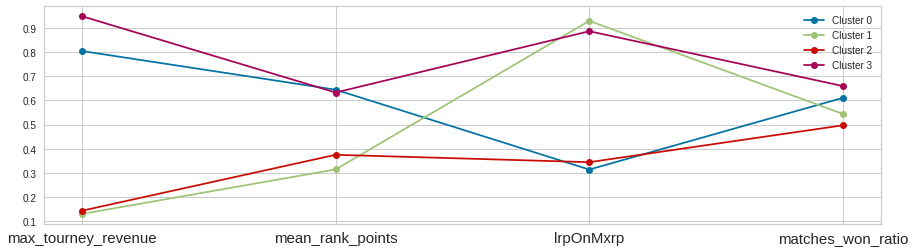

In [591]:
plt.figure(figsize=(15, 4))
for i in range(0, len(kmeans.cluster_centers_)):
    plt.plot(kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(0, len(df_data.columns)), df_data.columns, fontsize=15)
plt.legend(fontsize=10)
plt.show()

#### PCA visualization

In [592]:
df = df_players[df_players.select_dtypes(include = np.number).columns.tolist()].drop(columns = ['ht', 'mean_minutes', 'max_minutes', 'rel_ace', 'rel_df', 'rel_1stIn', 'rel_1stWon', 'rel_2ndWon', '1WonOn1In', '1WonOnTotWon', 'rel_ptsWon', 'rel_bpFaced', 'rel_bpSaved', 'rel_gmsWon'])
components_df = pd.DataFrame(PCA(n_components=2).fit_transform(df))
px.scatter(x=components_df[0], y=components_df[1], color=df_players["cluster_kmeans"]).show()

#### Scatter matrix of selected features

In [593]:
px.scatter_matrix(df_players,
    dimensions=feautures,
    color="cluster_kmeans")

#### Scatter matrix of interesting features

In [594]:
px.scatter_matrix(df_players,
    dimensions=interesting_features,
    color="cluster_kmeans")

#### Histograms of interesting features by gender
The only important difference between male and female players that can be seen is that female players tend to be more than the counterpart, nevertheless no discrimination is made

In [595]:
for feature in interesting_features:
  px.histogram(df_players, x=feature, facet_col="cluster_kmeans", color=df_players.gender).show()

#### Interpretation
Looking at the values ​​within the clusters, the following interpretation can be made:

- Players high ranked, played a lot of matches, performance *varies a lot* from one tournament to another
  - Cluster 0: decreasing performance and high age
  - Cluster 3: increasing performance and low age
- Players low ranked, played few matches, performance *varies* from one tournament to another
  - Cluster 2: decreasing performance and high age
  - Cluster 1: increasing performance and low age

In **summary** k-means identifies strong and weak players, and for both of them it identifies the ones with a rising score that are young and the ones with a decreasing score that are old. Stronger players have played more matches and attract more spectators and more money.

## Density-based

In [596]:
df_data = df_players[feautures].reset_index(drop=True)
df_data = pd.DataFrame(StandardScaler().fit_transform(df_data), columns=df_data.columns).round(3)
df_data.boxplot(column=feautures)

In [597]:
# pair-wise distance and then compute distance matrix
dist = pdist(X=df_data, metric='euclidean')
dist = squareform(dist)

kmin, kmax = 3, 30
kth_distances = {k:[] for k in range(kmin, kmax + 1)}

for d in dist:
    indexes_to_sort_d = np.argsort(d)
    for k in range(kmin, kmax + 1):
        kth_distances[k].append(d[indexes_to_sort_d[k]])

fig = go.Figure()
for k in kth_distances.keys():
    fig.add_trace(go.Scatter(x = np.array(range(0, len(kth_distances[k]))), y = sorted(kth_distances[k]), mode = 'lines' , name = str(k)))
fig.show()

### Find optimal hyper-parameters

In [598]:
def get_metrics(eps, min_samples, dataset, iter_):
    # Fit the model
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean noise point distance metric
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of clusters metric
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    return(noise_mean_distance, number_of_clusters)

eps_to_test = [round(eps,1) for eps in np.arange(0.1, 3, 0.1)]
min_samples_to_test = range(3, 30, 2)

# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

iter_ = 0
for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        iter_ += 1
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, df_data, iter_)

        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

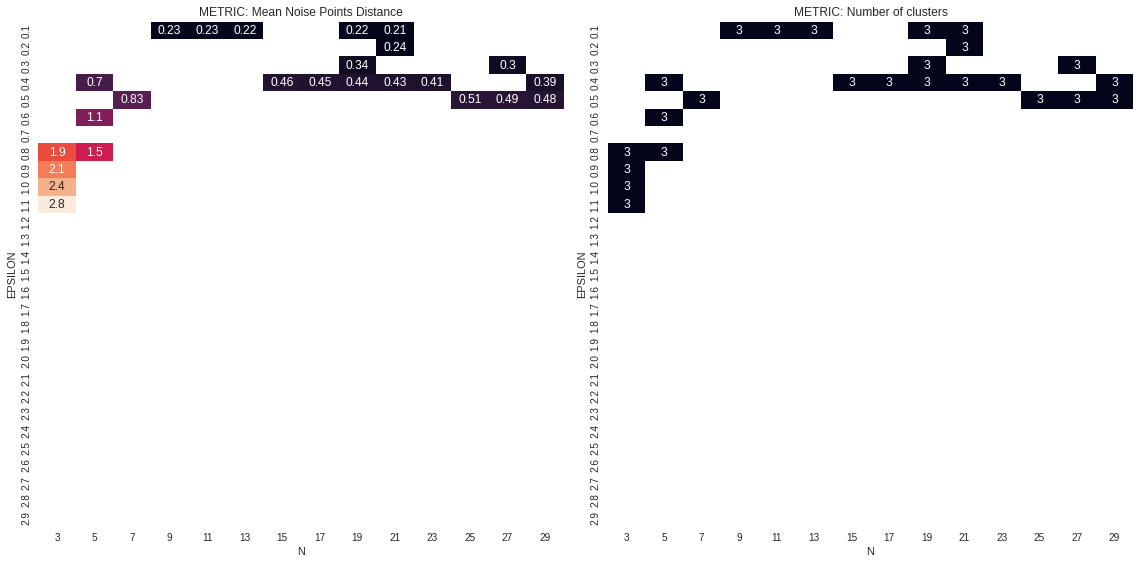

In [599]:
sm = (results_clusters >= 2) & (results_clusters <= 5)
sm = (results_clusters == 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )
sns.heatmap(results_noise[sm], annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters[sm], annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")
ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")
plt.tight_layout(); plt.show()

### Result analysis

In [600]:
# dbscan = DBSCAN(eps=0.9, min_samples=3).fit(df_data)
dbscan = DBSCAN(eps=0.4, min_samples=29).fit(df_data)
# -1: 977 players with 
# 0: young 20, increasing a lot
# 1: old 27, decreasing a lot
# 2: 23, stable
results = np.unique(dbscan.labels_, return_counts=True)
print(f"Clusters labels: {results[0]}\nElements per cluster: {results[1]}")

df_players["cluster_dbscan"] = dbscan.labels_.astype(str)
df_players.groupby("cluster_dbscan").mean()

Clusters labels: [-1  0  1  2]
Elements per cluster: [ 756 1883  312   46]


total_tourneys_played  total_matches_played  \
cluster_dbscan                                                
-1                          72.779101            153.458995   
0                           37.992034             74.192777   
1                          106.291667            234.131410   
2                           84.108696            160.652174   

                total_matches_won  matches_won_ratio  mean_performance_index  \
cluster_dbscan                                                                 
-1                      82.891534           0.484208                0.278279   
0                       36.792353           0.460180                0.249315   
1                      131.067308           0.559853                0.335260   
2                       76.978261           0.477495                0.261881   

                max_performance_index  min_performance_index  \
cluster_dbscan                                                 
-1                           0.732650               0.000220   
0                            0.614860               0.000531   
1                            0.878992               0.000000   
2                            0.802878               0.000000   

                performance_index_entropy          ht        age  \
cluster_dbscan                                                     
-1                               4.217873  181.051903  23.687038   
0                                3.578721  181.119048  20.279945   
1                                5.038514  180.925234  20.832666   
2                                4.544869  184.133333  26.115585   

                mean_minutes  max_minutes  minutes_entropy  mean_rank_points  \
cluster_dbscan                                                                 
-1                 95.185058   186.749288         3.818183        547.846104   
0                  87.923626   136.133183         1.005735         37.005596   
1                  98.515655   201.641026         4.690507        364.042510   
2                  93.817198   188.652174         4.556805        267.283430   

                max_rank_points  last_rank_points  variance_rank_points  \
cluster_dbscan                                                            
-1                  1045.312169        546.667989         276634.673501   
0                     64.976102         44.150292            571.018782   
1                    782.516026        727.185897          55139.983278   
2                    529.413043         98.717391          22016.429403   

                lrpOnAvgrp  lrpOnMxrp  mean_tourney_spectators  \
cluster_dbscan                                                   
-1                0.916243   0.498109              4650.397735   
0                 1.239723   0.741970              3294.840828   
1                 1.953233   0.913334              4735.582377   
2                 0.377010   0.194208              4448.549758   

                max_tourney_spectators  mean_tourney_revenue  \
cluster_dbscan                                                 
-1                        14027.066138         927513.133953   
0                          5407.307488         658012.334026   
1                         17092.538462         956276.464921   
2                         15373.608696         892054.511459   

                max_tourney_revenue   rel_ace    rel_df  rel_1stIn  \
cluster_dbscan                                                       
-1                     3.500421e+06  0.050905  0.050482   0.610053   
0                      1.148321e+06  0.036313  0.059128   0.602584   
1                      4.966772e+06  0.048648  0.046697   0.619256   
2                      3.725197e+06  0.055103  0.043570   0.618103   

                rel_1stWon  rel_2ndWon  1WonOn1In  1WonOnTotWon  rel_ptsWon  \
cluster_dbscan                                                                
-1                0.399178    0.181020   0.655169      0.687905    0.

#### PCA visualization

In [601]:
df = df_players[df_players.select_dtypes(include = np.number).columns.tolist()].drop(columns = ['ht', 'mean_minutes', 'max_minutes', 'rel_ace', 'rel_df', 'rel_1stIn', 'rel_1stWon', 'rel_2ndWon', '1WonOn1In', '1WonOnTotWon', 'rel_ptsWon', 'rel_bpFaced', 'rel_bpSaved', 'rel_gmsWon'])
components_df = pd.DataFrame(PCA(n_components=2).fit_transform(df))
px.scatter(x=components_df[0], y=components_df[1], color=df_players["cluster_dbscan"]).show()

#### Interpretation

In [602]:
df_players.groupby("cluster_kmeans").agg(pd.Series.mode)

name gender  \
cluster_kmeans                                                             
0               [adam pavlasek, adrian menendez maceiras, agni...      m   
1               [abbie myers, adelina baravi, adesuwa osabuohi...      f   
2               [abhinav sanjeev shanmugam, abigail tere apisa...      f   
3               [adrian mannarino, aidan mchugh, ajla tomljano...      f   

                total_tourneys_played  total_matches_played  \
cluster_kmeans                                                
0                                 116                   280   
1                                  16                    16   
2                                  17                    18   
3                                  63                   272   

                matches_won_ratio  max_performance_index  \
cluster_kmeans                                             
0                        0.485714               0.833333   
1                        0.500000               0.833333   
2                        0.500000               0.500000   
3                        0.555556               0.833333   

                min_performance_index              ht hand  \
cluster_kmeans                                               
0                                 0.0           185.0    r   
1                                 0.0  [168.0, 190.0]    u   
2                                 0.0           183.0    r   
3                                 0.0           183.0    r   

                                        max_minutes max_rank_points  \
cluster_kmeans                                                        
0                                             168.0           410.0   
1                                             168.0             4.0   
2                                             170.0             8.0   
3               [166.0, 168.0, 182.0, 189.0, 192.0]  [288.0, 511.0]   

                last_rank_points  lrpOnMxrp  max_tourney_spectators  \
cluster_kmeans                                                        
0                           40.0        0.4                 18086.0   
1                            3.0        1.0                  6203.0   
2                            3.0        0.5                 13004.0   
3                          269.0        1.0                 17634.0   

                max_tourney_revenue cluster_dbscan  
cluster_kmeans                                      
0                        5002793.97             -1  
1                        1436125.64              0  
2                        1725074.22              0  
3                        5002793.97              1

In [603]:
df_players.groupby("cluster_dbscan").mean().loc[:, ["mean_rank_points", "lrpOnAvgrp", "age", "total_matches_played", "mean_minutes", "matches_won_ratio"]].sort_values(by="mean_rank_points", ascending=False)
x = df_players.groupby("cluster_dbscan").agg({"cluster_kmeans":"count", "mean_rank_points": "mean", "lrpOnAvgrp": "mean", "age": "mean", "total_matches_played": "mean", "mean_tourney_revenue": "mean"}).sort_values(by="mean_rank_points", ascending=False)
x = x.round(2)
# rename column cluster_kmeans to cluster size
x.rename(columns={"cluster_kmeans": "cluster size"}, inplace=True)

import plotly.figure_factory as ff
ff.create_table(x, index=True, index_title="Cluster")

In [604]:
px.scatter_matrix(df_players,
    dimensions=feautures,
    color="cluster_dbscan")

In [605]:
px.scatter_matrix(df_players,
    dimensions=interesting_features,
    color="cluster_dbscan")

## Hierarchical

In [606]:
df_data = df_players[feautures].reset_index(drop=True)
df_data = pd.DataFrame(StandardScaler().fit_transform(df_data), columns=df_data.columns)
df_data = df_data.round(3)
df_data.boxplot(column=feautures)

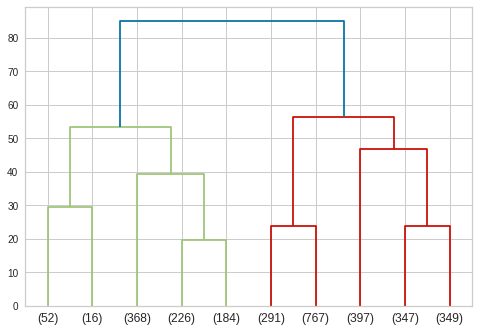

In [607]:
dend = linkage(df_data, method='ward', metric="euclidean")
dendrogram(dend, p = 10, truncate_mode = 'lastp')
plt.show()

In [615]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward', )
cluster.fit_predict(df_data)

results = np.unique(cluster.labels_, return_counts=True)
print(f"Clusters labels: {results[0]}\nElements per cluster: {results[1]}")

df_players["cluster_hierarchical"] = cluster.labels_.astype(str)
df_players = df_players.round(3)

Clusters labels: [0 1 2 3 4 5]
Elements per cluster: [210 400 596 236 777 778]


### Result analysis

In [621]:
df = df_players[df_players.select_dtypes(include = np.number).columns.tolist()].drop(columns = ['ht', 'mean_minutes', 'max_minutes', 'rel_ace', 'rel_df', 'rel_1stIn', 'rel_1stWon', 'rel_2ndWon', '1WonOn1In', '1WonOnTotWon', 'rel_ptsWon', 'rel_bpFaced', 'rel_bpSaved', 'rel_gmsWon'])
components_df = pd.DataFrame(PCA(n_components=2).fit_transform(df))
px.scatter(x=components_df[0], y=components_df[1], color=df_players["cluster_hierarchical"]).show()

### Post processing

In [617]:
df_players.loc[df_players["cluster_hierarchical"] == "1", "cluster_hierarchical"] = "0"
df_players.loc[df_players["cluster_hierarchical"] == "4", "cluster_hierarchical"] = "0"
df_players.loc[df_players["cluster_hierarchical"] == "5", "cluster_hierarchical"] = "0"


In [611]:
df_players.groupby("cluster_hierarchical").mean().loc[:, ["age", "mean_rank_points", "lrpOnAvgrp", "total_matches_played", "mean_minutes", "matches_won_ratio"]]

age  mean_rank_points  lrpOnAvgrp  \
cluster_hierarchical                                            
0                     21.493085         39.849061    0.848748   
1                     23.176861        409.115149    1.220652   
2                     19.451328         48.404140    1.598848   
3                     24.891074       2892.224794    1.248647   

                      total_matches_played  mean_minutes  matches_won_ratio  
cluster_hierarchical                                                         
0                                58.539799     87.183628           0.378569  
1                               200.059126     97.009235           0.530851  
2                                93.077505     89.784667           0.528268  
3                               265.485294    103.717853           0.640294

## Gaussian Mixture (EMA)

In [612]:
df_data = df_players[feautures].reset_index(drop=True)
#df_data = pd.DataFrame(MinMaxScaler().fit_transform(df_data), columns=df_data.columns)
df_data = df_data.round(3)

In [613]:
df = df_data.values.tolist()
ema_instance = ema(df, 5)
ema_instance.process()

# Get clustering results.
clusters = ema_instance.get_clusters()
covariances = ema_instance.get_covariances()
means = ema_instance.get_centers()
# Visualize obtained clustering results.
# ema_visualizer.show_clusters(clusters, sample, covariances, means)
# x = cluster_visualizer_multidim()
# x.append_clusters(clusters, df)
# x.show()
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {len(cluster)}")

for i, cluster in zip(range(len(clusters)), clusters):
    df_players.loc[df_players.index[cluster], 'cluster_gm'] = str(i)

df_players.groupby("cluster_gm").mean().loc[:, ["age", "mean_rank_points", "lrpOnAvgrp", "total_matches_played", "mean_minutes", "matches_won_ratio"]]

Cluster 0: 236
Cluster 1: 596
Cluster 2: 2155
Cluster 3: 10


age  mean_rank_points  lrpOnAvgrp  total_matches_played  \
cluster_gm                                                                  
0           24.965305        361.178716    0.786479            142.491525   
1           22.432889        722.205800    1.528948            237.562081   
2           20.570702         43.622040    1.181874             74.576334   
3           20.396200          5.114500    1.003700             23.200000   

            mean_minutes  matches_won_ratio  
cluster_gm                                   
0              94.884735           0.502860  
1              99.080399           0.560695  
2              88.391148           0.452763  
3              56.706000           0.067300

### Result analysis

In [614]:
# TODO remove these line if you want to plot over the normalized data where k-means was executed
df = df_players[df_players.select_dtypes(include = np.number).columns.tolist()].drop(columns = ['ht'])

components_df = pd.DataFrame(PCA(n_components=2).fit_transform(df))
px.scatter(x=components_df[0], y=components_df[1], color=df_players["cluster_dbscan"]).show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
df_players.groupby("cluster_gm").mean()

total_tourneys_played  total_matches_played  total_matches_won  \
cluster_gm                                                                   
0                       40.666667             72.666667          32.500000   
1                      109.094991            240.493955         135.070812   
2                       12.000000             24.736842          12.684211   
3                       72.909574            145.909574          74.101064   
4                       33.753425             62.897260          29.193493   

            matches_won_ratio  mean_performance_index  max_performance_index  \
cluster_gm                                                                     
0                    0.455833                0.222333               0.638833   
1                    0.560209                0.331915               0.874002   
2                    0.514263                0.280316               0.526263   
3                    0.497223                0.280340               0.791202   
4                    0.422027                0.223676               0.584318   

            min_performance_index  performance_index_entropy          ht  \
cluster_gm                                                                 
0                        0.000000                   3.800000  186.333333   
1                        0.000000                   5.073098  180.817881   
2                        0.000000                   2.868263  186.500000   
3                        0.000000                   4.415660  181.329114   
4                        0.000286                   3.317197  184.041667   

                  age  mean_minutes  max_minutes  minutes_entropy  \
cluster_gm                                                          
0           32.406167     94.295833   183.166667         4.061333   
1           22.606249     99.153157   209.946459         4.950010   
2           25.286895     91.411842   159.368421         3.095789   
3           26.094255     95.298899   187.648936         4.317532   
4           23.069057     91.922764   168.775685         3.570267   

            mean_rank_points  max_rank_points  last_rank_points  \
cluster_gm                                                        
0                 343.996500       538.500000        157.833333   
1                 740.318054      1487.514680        988.854922   
2                  38.295842        56.473684         40.368421   
3                 424.840133       745.180851        231.776596   
4                  85.202361       144.957151         79.109432   

            variance_rank_points  mean_tourney_spectators  \
cluster_gm                                                  
0                   13000.305000              4401.417000   
1                  361775.174295              5179.392865   
2                     256.214737              3148.662263   
3                   88859.690606              4652.105787   
4                    2433.373320              3825.123094   

            max_tourney_spectators  mean_tourney_revenue  max_tourney_revenue  \
cluster_gm                                                                      
0                     15084.500000          8.173080e+05         2.501610e+06   
1                     17417.715026          1.039635e+06         4.933715e+06   
2                      4240.105263          6.407513e+05         9.400204e+05   
3                     15531.351064          9.318422e+05         3.731152e+06   
4                      8459.719178          7.598282e+05         1.760906e+06   

             rel_ace    rel_df  rel_1stIn  rel_1stWon  rel_2ndWon  1WonOn1In  \
cluster_gm                                                                     
0           0.062333  0.041500   0.591833    0.410833    0.197667   0.694500   
1           0.052824  0.045946   0.618100    0.412579    0.183915   0.669263   
2           0.055684  0.049053   0.600474    0.417158    0.199421   0.696000   
3           0.052941 